In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd
from skimage.transform import resize

# Bouts
from utils.utils_bouts import NameCat

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

# Pipeline
from tracking_data.dataset import Dataset_TailTracking
from pipeline.tail_tracking import PipelineTailTracking
from pipeline.cfg import ConfigTailPreprocess,ConfigSparseCoding,ConfigTailSegmentationClassification


In [14]:

data_folder='H://HeadRestrainedDataset//all_csv//'
protocol_name='all_csv'
path='H://HeadRestrainedDataset//all_csv//'

filelist=[]
for file in os.listdir(path):
    if file.endswith(".csv"):
        filelist.append(os.path.join(path, file))


In [15]:
filelist = ['2021-10-07-nefma-7dpf-f1-all_logs']

Tensor = np.zeros((3500,10,0))
stop = False
df = pd.read_csv('H://HeadRestrainedDataset//all_csv//'+filelist[0]+'.csv')
#df = pd.read_csv(filelist[0])

NumSegment = 16

relative_tail_angle = df[['angle'+str(i) for i in range(NumSegment)]]
relative_tail_angle = relative_tail_angle.values

cumul_tail_angle=np.cumsum(relative_tail_angle,1)
cumul_tail_angle[cumul_tail_angle<-10]=np.nan

tracking_data = Dataset_TailTracking(fps=700,tail_angle=cumul_tail_angle)

tail_angle was rescaled to have size to have 10 segments


# Create Pipeline

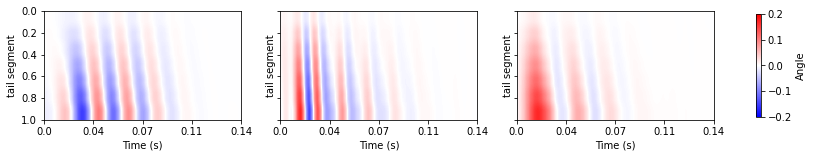

In [16]:

Dict = np.load('./sparse_coding/3atomsDictTu.npy')

D = Dict

fig, (ax) = plt.subplots(1,3,figsize=(15,2), sharex=True,sharey=True)#,constrained_layout=True)

for i in range(D.shape[-1]):
    #ax[i].title(str(i))
    im = ax[i].imshow(D[:,:,i].T,aspect='auto',vmin=-0.2,vmax=0.2,cmap='bwr',extent=[0,100,1,0])
    ax[i].set_ylabel('tail segment')
    #ax[i,0].set_xlabel('Time (s)')
    ax[i].set_xticks(np.linspace(0,100,5))
    ax[i].set_xticklabels(np.round(np.linspace(0,100/700,5),2))


ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')
ax[2].set_xlabel('Time (s)')

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label('Angle')
plt.show()

In [77]:
cfg_preprocess = ConfigTailPreprocess(fps=700,num_pcs=3,limit_na_ms=100,
                                      baseline_method='whittaker',baseline_params={'fps':700,'lmbda':1e4})

cfg_sparse_coding = ConfigSparseCoding(fps=700,Dict=Dict,lmbda=0.01,gamma=0.15,mu=0.15,window_inhib_ms=85)

cfg_segment_classify = ConfigTailSegmentationClassification(fps=700,
                                                            min_code_height=1,min_spike_dist_ms=200,
                                                            margin_before_peak_ms=32,
                                                            bout_duration_ms=200,
                                                            augment_max_delay_ms=18,
                                                            augment_step_delay_ms=2,
                                                            feature_weight=np.ones(7),
                                                            N_kNN=10)


pipeline = PipelineTailTracking(cfg_preprocess,
                                cfg_sparse_coding,
                                cfg_segment_classify,
                                load_training=True)

# Tuning baseline parameter fc

In [78]:
tail_angle_clean,baseline = pipeline.preprocess(tracking_data.tail_angle)

In [79]:
'''from preprocessing.baseline import compute_baseline

x = tail_angle_clean[:,6]

#baseline = compute_baseline(x,method='slow', params = {'fps':700})
#baseline = compute_baseline(x,method='beads', params = {'fps':700,'fc':0.001,'lmbda':1})
baseline = compute_baseline(x,method='whittaker', params = {'fps':700,'lmbda':5*1e3})'''

"from preprocessing.baseline import compute_baseline\n\nx = tail_angle_clean[:,6]\n\n#baseline = compute_baseline(x,method='slow', params = {'fps':700})\n#baseline = compute_baseline(x,method='beads', params = {'fps':700,'fc':0.001,'lmbda':1})\nbaseline = compute_baseline(x,method='whittaker', params = {'fps':700,'lmbda':5*1e3})"

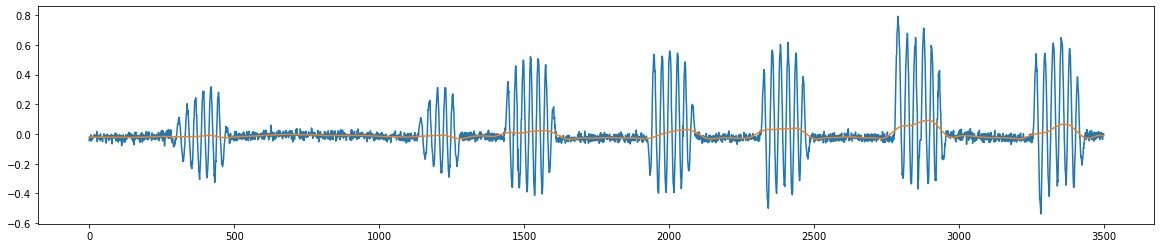

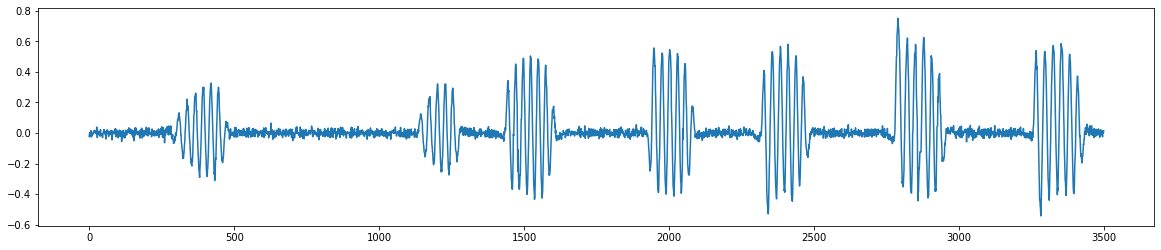

In [80]:
Duration = 700*5
IdSt = np.random.choice([1099654,1241450,915610,232389,285738])
#IdSt = np.random.randint(len(x))
plt.figure(figsize=(20,4))
plt.plot(tail_angle_clean[IdSt:IdSt+Duration,6])
plt.plot(baseline[IdSt:IdSt+Duration,6])
plt.show()

plt.figure(figsize=(20,4))
plt.plot((tail_angle_clean-baseline)[IdSt:IdSt+Duration,6])
plt.show()

In [81]:
tail_angle_detrend,baseline,z,tail_angle_hat,decomposition,segments,segment_refined,tail_array,bout_category,id_nearest_template = pipeline.run(tracking_data.tail_angle)

Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  7.10e+03  4.75e+03  2.40e+04  7.76e+03  6.31e+03  4.18e-01  8.69e+00  1.50e+00
   1  1.27e+04  4.02e+03  3.39e+04  3.15e+04  2.37e+04  6.28e-01  1.10e+00  1.50e+00
   2  1.41e+04  5.34e+03  2.61e+04  3.57e+04  2.07e+04  9.47e-01  3.50e-01  1.10e+00
   3  1.30e+04  5.61e+03  1.92e+04  2.92e+04  1.86e+04  8.01e-01  1.53e-01  1.77e+00
   4  1.18e+04  6.13e+03  1.40e+04  2.16e+04  1.56e+04  3.33e-01  4.01e-01  3.94e+00
   5  1.33e+04  5.85e+03  1.63e+04  2.64e+04  2.23e+04  2.27e-01  2.42e-01  3.49e+00
   6  1.23e+04  5.66e+03  1.42e+04  2.13e+04  2.22e+04  1.94e-01  2.01e-01  3.49e+00
   7  1.18e+04  5.85e+03  1.26e+04  1.82e+04  2.05e+04  1.86e-01  1.08e-01  3.49e+00
   8  1.15e+04  6.07e+03  1.15e+04  1.59e+04  1.98e+04  1.01e-01  1.03e-01  4.47e+00
   9  1.16e+04  6.04e+03  1.15e+04  1.50e+04  2.14e+04  7.12e-02 

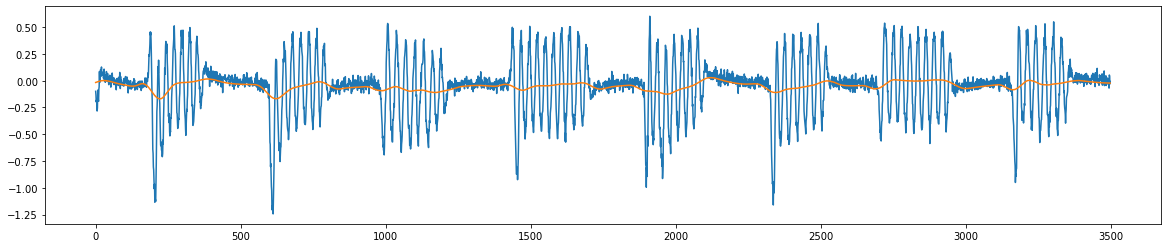

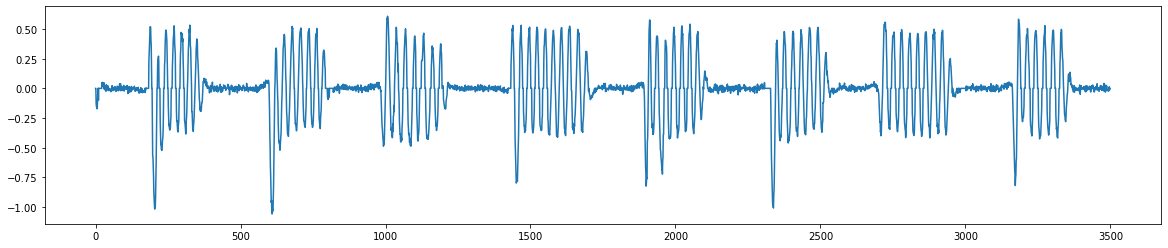

In [82]:
Duration = 700*5
IdSt= np.random.randint(baseline.shape[0]-Duration)

plt.figure(figsize=(20,4))
plt.plot(tracking_data.tail_angle[IdSt:IdSt+Duration,6])
plt.plot(baseline[IdSt:IdSt+Duration,6])
plt.show()
plt.figure(figsize=(20,4))
plt.plot(tail_angle_detrend[IdSt:IdSt+Duration,6])
plt.show()


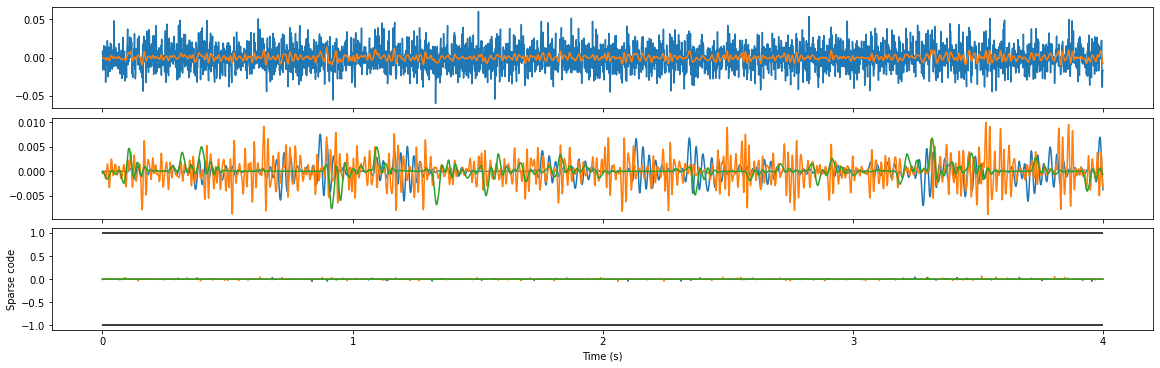

In [83]:
Duration = 700*5
IdSt= np.random.randint(baseline.shape[0]-Duration)

fig, (ax) = plt.subplots(3,1,figsize=(16,5), sharex=True,constrained_layout=True)
ax[0].plot(tail_angle_detrend[IdSt:IdSt+Duration,-1])
ax[0].plot(tail_angle_hat[IdSt:IdSt+Duration,-1])
ax[1].plot(decomposition[IdSt:IdSt+Duration,:])
ax[2].plot(z[IdSt:IdSt+Duration,:])
ax[2].hlines(cfg_segment_classify.min_code_height,0,Duration,color='k')
ax[2].hlines(-cfg_segment_classify.min_code_height,0,Duration,color='k')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Sparse code')
ax[2].set_xticks(np.linspace(0,Duration,5))
ax[2].set_xticklabels(np.arange(0,5))
plt.show()

In [84]:
templates_labels = pipeline.knn_training_dataset_augmented.labels
print(tail_array.shape)

(994, 7, 140)


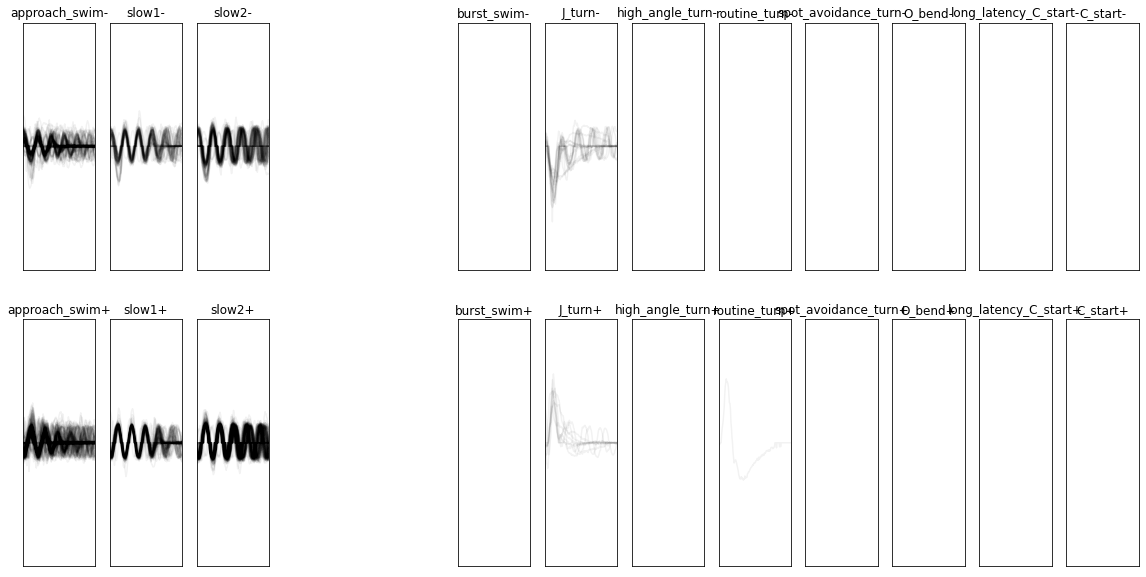

In [85]:
fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    id = np.where(bout_category==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(tail_array[id,-1,:].T,'k',alpha=0.05)

    ax0.set_xlim(0,cfg_segment_classify.bout_duration)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


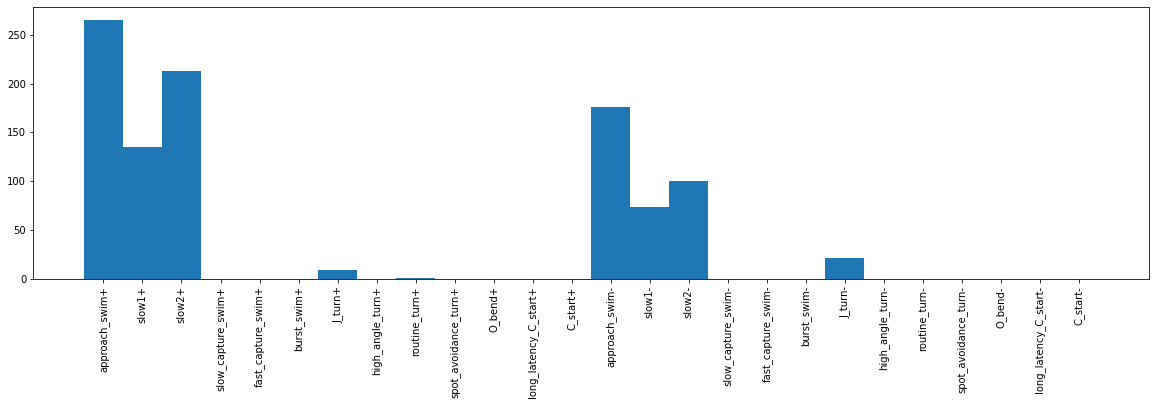

In [86]:
fig, ax = plt.subplots(facecolor='white',figsize=(20,5)) 
plt.hist(bout_category,np.linspace(-0.5,25.5,27))
plt.xticks(np.arange(26),NameCat, rotation='vertical')
plt.show()

# Make Figure 2

In [87]:
from utils.utils_bouts import compute_bout_cat_ts


In [88]:
bout_cat_ts,bout_cat_ts_signed = compute_bout_cat_ts(segments.onset,
                                                     segments.offset,
                                                     bout_category,
                                                     tail_angle_clean.shape[0])

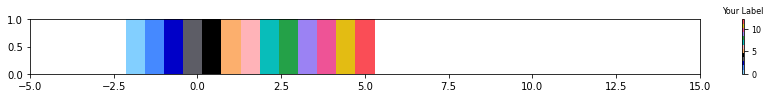

In [89]:
from utils.utils_plot import NameCatSym_w_CS,list_color_w_CS,cmp_bouts
plt.figure(figsize=(15,1))
plt.imshow(np.arange(-5,30)[:,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[-5,15,0,1])
clb=plt.colorbar()
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('Your Label',fontsize=8)
plt.show()

In [90]:
fps = cfg_preprocess.fps
Duration = fps*7
IdSt = np.random.randint(tail_angle_clean.shape[0])
IdEd = IdSt + Duration
t = np.linspace(0,Duration/700,Duration)

sub_onset,sub_offset,sub_i= [],[],[]
for i,(on_,off_) in enumerate(zip(segments.onset,segments.offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)
sub_i = np.array(sub_i)
sub_onset = np.array(sub_onset)
sub_offset = np.array(sub_offset)

sub_tail_array = tail_array[sub_i,:7,:]
id = id_nearest_template[sub_i]
tail_nearest = pipeline.knn_training_dataset_augmented.tail[id,:,:]

sub_onset = sub_onset-IdSt
sub_offset = sub_offset-IdSt

(0.0, 7.0)

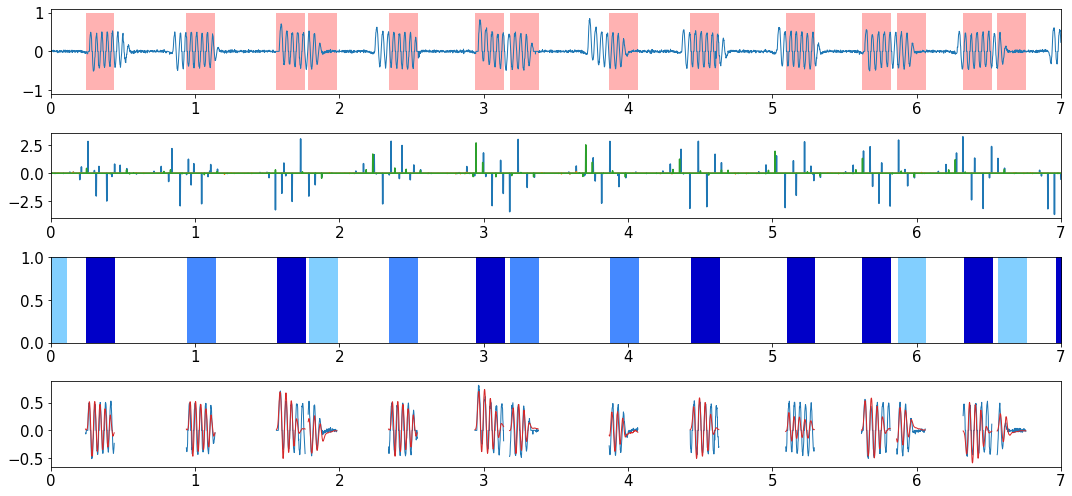

In [91]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(facecolor='white',figsize=(15,7),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(4,1)

ax = plt.subplot(G[0])
ax.plot(t,tail_angle_detrend[IdSt:IdEd,-1],lw=1)
#ax.plot(t,df.tail_active.values[IdSt:IdEd])
for p in sub_onset:
    ax.add_patch(Rectangle((t[p],-1),140/700,2,facecolor="red",alpha=0.3))
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[1])
ax.plot(t,z[IdSt:IdEd,:])
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[2])
ax.imshow(bout_cat_ts[IdSt:IdEd,np.newaxis].T,
          cmap=cmp_bouts,
          aspect='auto',
          vmin=0,vmax=12,
          interpolation='nearest',extent=[0,Duration/fps,0,1])
ax.set_xlim(0,Duration/fps)

ax = plt.subplot(G[3])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    #ax.plot((np.arange(on_,off_))/fps,tail_angle_detrend[on_+IdSt:off_+IdSt,-1],'tab:blue')
    ax.plot((np.arange(on_,off_))/fps,sub_tail_array[i,-1,:],'tab:blue',lw=1)
    #off_ = on_+140
    ax.plot((np.arange(on_,off_))/fps,tail_nearest[i,-1,:],'tab:red',lw=1)
ax.set_xlim(0,Duration/fps)
